# How to deal with input and output of subkernels

* **Difficulty level**: easy
* **Time need to lean**: 10 minutes or less
* **Key points**:
  * `%expand` treats input of cell as a Python f-string and expand it before sendint to subkernel
  * `%capture` captures output from subkernels and save them into Python variables
  * `%render` renders output from subkernels in different formats
  

## <a id="magic_expand"></a>`%expand` 

Script in SoS cells are by default sent to SoS or the subkernels in verbatim. However, similar to the `expand` option of the SoS actions, you can interpolate scripts before they are executed by the kernels. Basically,

1. By default, scripts are not interpolated.
2. With `%expand` magic, scripts are treated as Python f-string and are interpolated with sigil `{ }`
3. With `%expand ${ }` or other sigils, scripts are interpolated with specified sigil so that you can avoid using symbols that already used in the script.

As you can imagine, string interpolation allows passing information from the SoS kernel to the subkernels. Although this method is less flexible and powerful than inter-kernel variable exchange using magics such as `%get`, it is sometimes easier to use and can be especially useful if you plan to include the script as a SoS action in a SoS workflow.

For example,

In [8]:
par = 100

In [9]:
%expand
cat("A parameter {par} is specified.")

A parameter 100 is specified.

If the script contains `{ }`, which is quite common in R, you can double the braces 

In [10]:
%expand
if ({par} > 50) {{
    cat("A parameter {par} greater than 50 is specified.");
}}

A parameter 100 greater than 50 is specified.

If there are multiple braces, it is obviously better to use a different sigil, such as `${ }` to interpolate the script

In [11]:
%expand ${ }
if (${par} > 50) {
    cat("A parameter ${par} greater than 50 is specified.");
}

A parameter 100 greater than 50 is specified.

### <a id="magic_get"></a>`%get` 

Magics `%get` retrieve variables from SoS or another subkernel to the current subkernel started by magic `%use`.

For example,

In [12]:
%use sos
a = [1, 2, 3]
b = [1, 2, "3"]
c = True

In [13]:
%use R
%get a b c
a

[1] 1 2 3

In [14]:
b

[[1]]
[1] 1

[[2]]
[1] 2

[[3]]
[1] "3"

In [15]:
c

[1] TRUE

The `%preview` magic cannot be used to preview variables in the subkernel so we have to list them one by one. As you can see, a Python list can be converted to `R` array or list depending on its content. 

Similar to the `%put` magic, SoS automatically translate variables with invalid Python names. For example

In [16]:
%use sos
_var = 'Hi, Bob'

In [17]:
%use R
%get _var
.var

Variable _var is passed from SoS to kernel ir as .var


[1] "Hi, Bob"

In [18]:
%use sos

Also similar to the `--to` option of magic `%put`, magic `%get` accept a parameter `--from` to get variables from SoS (default) any kernel. For example,

In [19]:
R_var <- 'R variable'

In [20]:
%get --from R R_var
R_var

'R variable'

Depending on how the language module is defined, such cross-subkernel variable exchange can be achived directly, or by way of SoS, so after the `%get --from R R_var` statement, the `R_var` variable might or might not exist in the SoS kernel.

## <a id="magic_render"></a>`%render` 

The `%render` magic converts the output of a cell to certain format before displaying it in the notebook. The format can be any format supported by the [`IPython.display` module](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html) and is default to `Markdown`. For example, the following code displays all supported options of `%render` by checking the subclasses of `IPython.display`. The cell returns a string in markdown format and is rendered in `Markdown`.

In [1]:
%render
import IPython.display
import inspect

res = '''
Options of magic %render

'''

for key in IPython.display.__dict__.keys():
    cls = getattr(IPython.display, key)
    if inspect.isclass(cls) and issubclass(cls, IPython.display.DisplayObject):
        res += '* {}\n'.format(key)

# this is the output of this cell and will be rendered in Markdown format
res


Options of magic %render

* DisplayObject
* TextDisplayObject
* Pretty
* HTML
* Markdown
* Math
* Latex
* SVG
* ProgressBar
* JSON
* GeoJSON
* Javascript
* Image
* Video
* Audio
* Code


Similarly, you can use magic `%render` to render output in other formats:

In [2]:
%render --as HTML
'''
This is a table in HTML format <br>
<table style="width:100%">
  <tr>
    <th>Firstname</th>
    <th>Lastname</th> 
    <th>Age</th>
  </tr>
  <tr>
    <td>Jill</td>
    <td>Smith</td> 
    <td>50</td>
  </tr>
  <tr>
    <td>Eve</td>
    <td>Jackson</td> 
    <td>94</td>
  </tr>
</table>
'''

Firstname,Lastname,Age
Jill,Smith,50
Eve,Jackson,94


The `%render` magic captures not only the return value of SoS cell, but also standard output of SoS and other cells. For example, a subprocess of the following cell (a Python script) prints the content of a SVG file to standard output, which is captured and displayed by magic `%render`.


 <svg height="140" width="140">
  <defs>
    <filter id="f1" x="0" y="0" width="200%" height="200%">
      <feOffset result="offOut" in="SourceAlpha" dx="20" dy="20" />
      <feGaussianBlur result="blurOut" in="offOut" stdDeviation="10" />
      <feBlend in="SourceGraphic" in2="blurOut" mode="normal" />
    </filter>
  </defs>
  <rect width="90" height="90" stroke="green" stroke-width="3" fill="yellow" filter="url(#f1)" />
  Sorry, your browser does not support inline SVG.
 </svg>



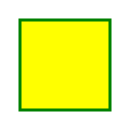

In [3]:
%render --as SVG
python:
print(r'''
 <svg height="140" width="140">
  <defs>
    <filter id="f1" x="0" y="0" width="200%" height="200%">
      <feOffset result="offOut" in="SourceAlpha" dx="20" dy="20" />
      <feGaussianBlur result="blurOut" in="offOut" stdDeviation="10" />
      <feBlend in="SourceGraphic" in2="blurOut" mode="normal" />
    </filter>
  </defs>
  <rect width="90" height="90" stroke="green" stroke-width="3" fill="yellow" filter="url(#f1)" />
  Sorry, your browser does not support inline SVG.
 </svg>
''')

The `%render` magic also works for other kernels although it can be tricky to determine what is printed to standard output. For kernel R, the function to print to standard output is `cat` so you can use `cat` to print something to the standard output for `%render` to process. For example,

In [4]:
%render
a <- rnorm(5)
cat(paste(length(a), "random numbers"))
cat(paste('*', a, collapse='\n'))

5 random numbers* -1.50442651757407
* -0.977242498620981
* 0.534575832846015
* -0.390538801124654
* 0.107239275008704

5 random numbers* -1.50442651757407
* -0.977242498620981
* 0.534575832846015
* -0.390538801124654
* 0.107239275008704

Finally, it worth noting that `%render` captures `stdout` by default but it can also capture and render text from `text/html` from `display_data` messages. This requires a parameter `text` after `%render`. Please check the details about this capture mechanism from magic `%capture`.

## Further reading

* 